# General Index Labeling Test
Small scale testing of general index data & processing

---
Created 6/14/22 by Ian Hay

### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[NetworkX](https://networkx.org/)  
[pyvis](https://pyvis.readthedocs.io/en/latest/install.html)   
[scikit-learn](https://scikit-learn.org/stable/index.html)

In [9]:
from time import time
import pandas as pd
import numpy as np
import itertools
import nltk
import gensim
import spacy
nlp = spacy.load("en_core_web_sm")
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from pyvis import network as net
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.preprocessing import StandardScaler

### Functions

In [28]:
# Data Processing ------------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """"""
    strDict = {}
    for row in range(len(df)):
        text = " ".join(df.iloc[row][column])
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getNounsAndVerbs(df, column, newColumnName):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    """
    nounAndVerbDict = {}
    for row in range(len(df)):
        text = " ".join(df.iloc[row][column])
        doc = nlp(text)
        nounList = [chunk.text for chunk in doc.noun_chunks]
        verbList = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        nounAndVerbDict[df.index[row]] = nounList + verbList
    dfNounAndVerb = pd.Series(nounAndVerbDict, name=newColumnName)
    df[newColumnName] = dfNounAndVerb

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)))
    for n in range(len(df)):
        df[newColumnName][n] = scaledSeries[n] + 1 # scales most (~98%) to be in range [0, 2] for graphing purposes

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """

    ### deprecated ###

    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df[newColumnName].iloc[row] = string_list
    return df

def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                adjMatrix[n1][n2] = numSimilar 
    return adjMatrix

def buildAdjacencyListByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency list
    as a nestd dictionary with  n  keys in the outermost dict, where
    n  is the number of rows in the dataframe.
    The adjacency list edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])

    adjDict = {} # consider using the hash to represent nodes instead of numbers
    for n1 in range(n):

        nodeDict = {}
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                nodeDict[n2] = {"weight" : numSimilar} # https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html
        adjDict[n1] = nodeDict

    return adjDict

In [3]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame()
    for line in data:
        lineSplit = line.split(splittingChar)
        df = df.append([lineSplit]) # pandas gives a warning for this
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

In [17]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def drawNetworkgraph(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
    
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        height: height in px or %, e.g, "750px" or "100%
        width: width in px or %, e.g, "750px" or "100%
        bgcolor: background color, e.g., "black" or "#222222"
        font_color: font color,  e.g., "black" or "#222222"
        pyvis_options: provide pyvis-specific options (https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.options.Options.set)
    """

    # make a pyvis network
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # pyvis-specific options
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # return and also save
    return pyvis_graph.show(output_filename)


### Building Dataframe

In [5]:
# hard coded things

columnDict = {0: "hash", 1: "ngram", 2: "ngram_lc", 3: "ngram_num_tokens", 4: "ngram_count", 5: "term_freq", 6: "doc_count"}
non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]
filenameAnte = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennig = "data/doc_ngrams/sample.fgrep.Hennig86.txt"

In [6]:
# load test files into dataframe

indexCol = columnDict[0]
yakeScoreCol = columnDict[5]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnte)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennig)
df = pd.concat([df_antedivulian, df_hennig])
df.drop(7, axis=1, inplace=True)
df.rename(columns=columnDict, inplace=True)
df = df.groupby(indexCol).agg(list)

for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol][n] = term_freq_list[0]
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

df = getUniqueWordsColumn(df, "ngram_lc", "ngram_words", nonWords=non_words)
df["normalized_term_freq"] = np.zeros(len(df))
standardizeDataColumn(df, yakeScoreCol, "normalized_term_freq")
getNounsAndVerbs(df, "ngram_lc", "ngram_lc_nounsAndVerbs")
df = getUniqueWordsColumn(df, "ngram_lc_nounsAndVerbs", "ngram_unique_nounsverbs")
getDocColumn(df, "ngram_lc_nounsAndVerbs", "ngram_lc_doc_nounverb")
df.head()

/var/folders/96/s8vtyz9x38v4szdk13kx7g6w0000gn/T/ipykernel_7946/3817102458.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([lineSplit]) # pandas gives a warning for this
/var/folders/96/s8vtyz9x38v4szdk13kx7g6w0000gn/T/ipykernel_7946/3817102458.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([lineSplit]) # pandas gives a warning for this
/var/folders/96/s8vtyz9x38v4szdk13kx7g6w0000gn/T/ipykernel_7946/3817102458.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([lineSplit]) # pandas gives a warning for this
/var/folders/96/s8vtyz9x38v4szdk13kx7g6w0000gn/T/ipykernel_7946/3817102458.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pan

,ngram,ngram_lc,ngram_num_tokens,ngram_count,term_freq,doc_count,ngram_words,normalized_term_freq,ngram_lc_nounsAndVerbs,ngram_unique_nounsverbs
hash,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","[1, 2]","[1, 1]",0.000010,"[1, 1]","[antediluvian, humanity]",0.345035,[antediluvian antediluvian humanity],"[antediluvian, humanity]"
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","[1, 2, 4, 5]","[1, 1, 1, 1]",0.000281,"[1, 1, 1, 1]","[refrain, antediluvian, follow]",0.995948,"[antediluvian antediluvian refrain follow, an ...","[antediluvian, refrain, follow, an]"
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","[1, 2, 4, 5, 5]","[1, 1, 1, 1, 1]",0.000091,"[1, 1, 1, 1, 1]","[antediluvian, cave, dream, mammoth]",0.540615,"[antediluvian antediluvian dream cave, -pron- ...","[antediluvian, cave, dream, -pron-, mammoth]"
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","[2, 4, 5, 1]","[1, 1, 1, 1]",0.000198,"[1, 1, 1, 1]","[hennig86, routine, program]",0.797378,"[hennig86 program routine, the hennig86 routin...","[the, hennig86, routine, program]"
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],[1],[1],0.000051,[1],[antediluvian],0.443641,[],[]


In [12]:
df.shape

(768, 10)

### Performance Testing

In [ ]:
# to do
#
#   DONE  - test adj list vs adj matrix storage
#   DONE  - test adj list vs adj matrix compute performance
#   DONE  - test building each with ngrams vs keywords
# 
# - test performance and storage of scipy sparse matrix
# - test partitioning with ngrams vs keywords
# - test topic extraction with ngrams vs keywords
# - test visualizing with ngrams vs keywords
#
# (figure out how to validate patitioning and topic extraction)
# - test different community partition algos
# - test different topic extraction algos

In [ ]:
from timeit import Timer
funcList = ["buildAdjacencyMatrixByColumn", "buildAdjacencyListByColumn"]
parameterList = ["ngram_lc"]
numTests = 100

testingDict = {}
for func in funcList:
    thisTest = {}
    for param in parameterList:
        funcString = func + "(df, \"" + param + "\")"
        importString = "from __main__ import " + func + " , df"
        t = Timer(funcString, importString)
        testTime = t.timeit(number=numTests)
        thisTest["compute time (seconds)"] = testTime / numTests
    testingDict[func] = thisTest

testingDict["buildAdjacencyMatrixByColumn"]["storage (bytes)"] = sys.getsizeof(buildAdjacencyMatrixByColumn(df, parameterList[0]))
testingDict["buildAdjacencyListByColumn"]["storage (bytes)"] = sys.getsizeof(buildAdjacencyListByColumn(df, parameterList[0]))

testDF = pd.DataFrame(testingDict)
testDF.to_csv("performance testing 1000 iterations.csv")
# storage in memory in bytes
# compute time in seconds
testDF

In [ ]:
# t = Timer("buildAdjacencyMatrixByColumn(df, \"ngram_words\")", "from __main__ import buildAdjacencyMatrixByColumn, df")
# t.timeit(number=100)

### Building Network and Community Partitioning

In [13]:
# initial community partition on all data

# column to build adajency matrix 
adjColumnName = "ngram_lc_nounsAndVerbs"

print("Building Adjacency Matrix...")
t0 = time()
adjMatrix = buildAdjacencyMatrixByColumn(df, adjColumnName)
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Networkx Graph...")
t0 = time()
G = nx.from_numpy_array(adjMatrix)
print("Done in %0.3fs.\n" % (time() - t0))

community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
community_sets = community_generator.louvain_communities(G, resolution=0.1)
print("Done in %0.3fs.\n" % (time() - t0))


numCommunities = 0
numNodes = len(adjMatrix[0])
nodes = list(range(numNodes))
scalingFactor = 5. # scales the node size for visibility

node_to_community = {}

for set in community_sets:
    for x in set:
        node_to_community[x] = numCommunities
    numCommunities = numCommunities + 1

print("Adding Node Metadata...")
t0 = time()
for n in nodes:
    # 'title': hash (i.e. dataframe index)
    # 'group': partition
    # 'value': topic (empty for now)
    # 'size': normalized YAKE score
    G.nodes[n]["title"] = df.index[n]
    G.nodes[n]["group"] = node_to_community[n]
    G.nodes[n]["size"] = df["normalized_term_freq"][n] * scalingFactor
print("Done in %0.3fs.\n" % (time() - t0))

Building Adjacency Matrix...
Done in 4.268s.

Building Networkx Graph...
Done in 0.011s.

Building Louvain Partitions...
Done in 0.261s.

Adding Node Metadata...
Done in 0.005s.



In [14]:
# remove nodes apart of sparse communities

community_sets_pared = []
X = 3

for com in community_sets:
    if (len(com) < X): # bypasses communities with fewer than X nodes
        continue
    else:
        community_sets_pared.append(com)

nodes_to_keep = list(itertools.chain(*community_sets_pared))

print("Adjacency Matrix size before: " + str(adjMatrix.shape))
adjMatrixReduced = (adjMatrix[nodes_to_keep].T)[nodes_to_keep].T  # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
print("Adjacency Matrix size after: " + str(adjMatrixReduced.shape) + "\n")

nodes_to_remove = subtractListsOfInts(nodes, nodes_to_keep)

print("Removing Nodes...")
t0 = time()
G.remove_nodes_from(nodes_to_remove)
print("Done in %0.3fs." % (time() - t0))
numCommunitiesRemoved = numCommunities - len(community_sets_pared)
print("Number of communities removed: " + str(numCommunitiesRemoved))

numCommunities = numCommunities - numCommunitiesRemoved

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (362, 362)

Removing Nodes...
Done in 0.000s.
Number of communities removed: 395


### Topic Extraction

Building Corpus...
done in 0.115s.

Fitting Corpus...
done in 2.598s.



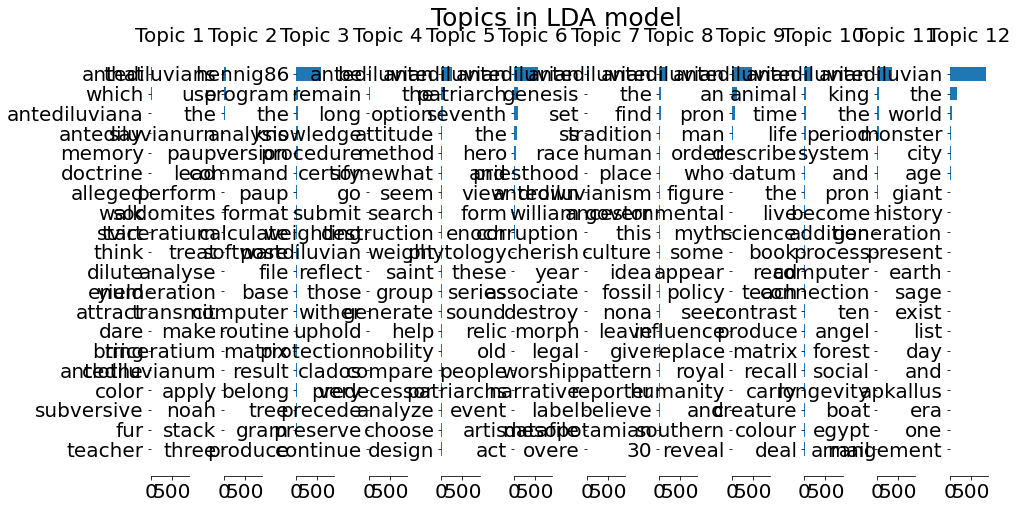

In [15]:
# on the whole data
vectorizer = CountVectorizer()
lda = LDA(n_components=numCommunities)

doc = []

print("Building Corpus...")
t0 = time()
for hash in df.index:
    hashDoc = df.loc[hash][adjColumnName]
    doc.append(hashDoc)
doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts
print("done in %0.3fs.\n" % (time() - t0))

print("Fitting Corpus...")
t0 = time()
lda.fit(X)
print("done in %0.3fs.\n" % (time() - t0))

cols = vectorizer.get_feature_names_out()
plot_top_words(lda, cols, n_top_words=20, title="Topics in LDA model", n_topics=numCommunities)

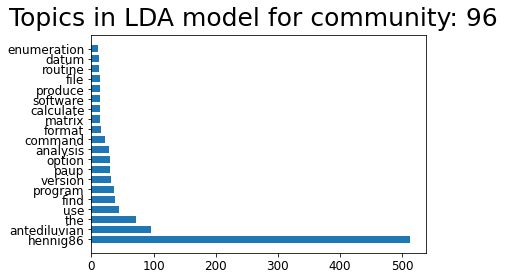

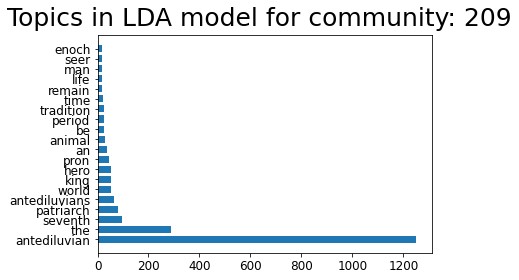

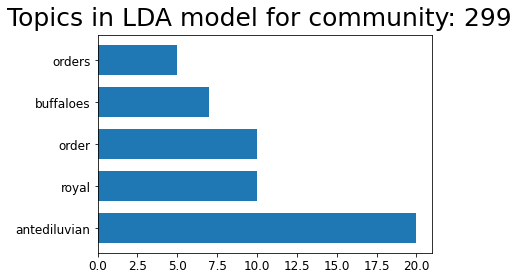

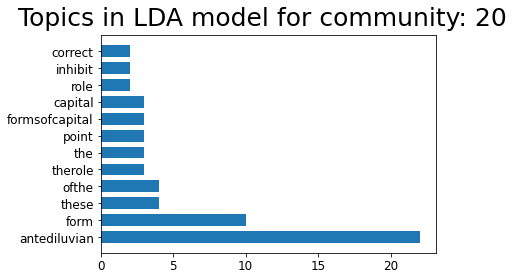

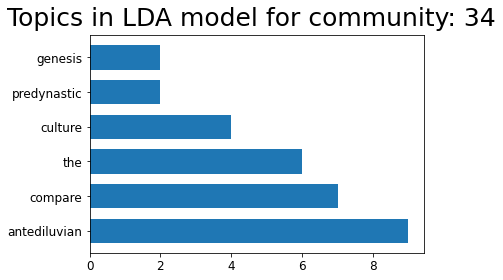

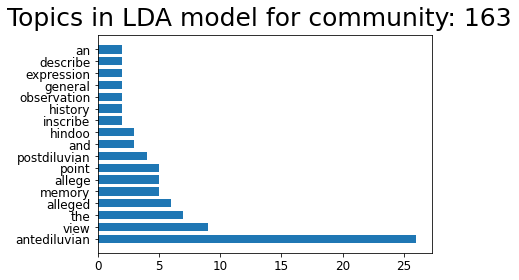

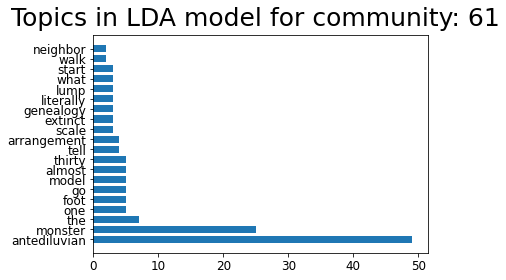

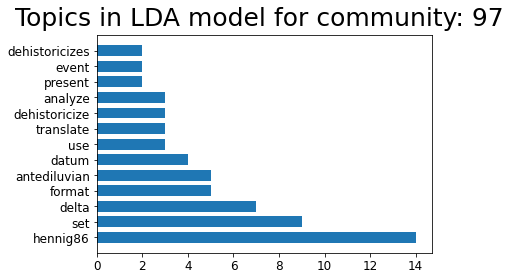

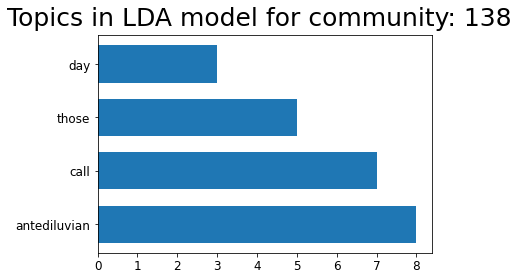

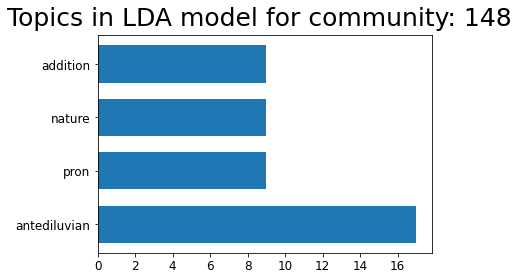

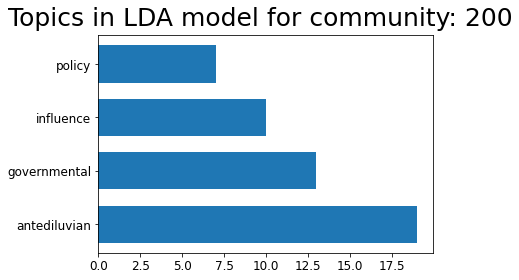

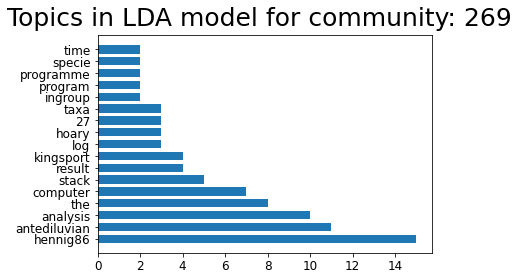

In [25]:
# on partitions of data

def filterNode(n1):
    return n1 in nodesInGroup

vectorizer = CountVectorizer()
numTopics = 1 # number of topics to pull out for each community

groupDict = nx.get_node_attributes(G, "group")
groupList = list(Counter(list(nx.get_node_attributes(G, "group").values())))

for community in groupList:

    # get the community's nodes
    nodesInGroup = [n for n in G.nodes if groupDict.get(n, "group")==community]
    subgraph = nx.subgraph_view(G, filter_node=filterNode)
    subgraphHashes = list(nx.get_node_attributes(subgraph, "title").values())

    # build the doc
    doc = []
    
    for hash in subgraphHashes:
        hashDoc = df.loc[hash][adjColumnName]
        doc.append(hashDoc)

    # fit the model
    doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
    X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts

    lda = LDA(n_components=numTopics)
    lda.fit(X)

    # add label to nodes
    cols = vectorizer.get_feature_names_out()
    feats = lda.components_[0]
    featDict = dict(zip(cols, feats))
    nodeLabel = max(featDict, key=featDict.get)
    for n in nodesInGroup:
        G.nodes()[n]["value"] = nodeLabel # figure out how to pull the top 3-5 words

    # plot the topic
    plot_top_words_one_topic(lda, cols, n_top_words=20, title=f"Topics in LDA model for community: {community}")

### Network Visualization

In [ ]:
# takeaways
#
# for LDA and community generation, including all similarities in edge weights performs best.
# for visualization, its incredibly slow.
#
# removing edges with weight=1 increases visualization runtime and readability, but 
# results in worse performing LDA and community generation

In [26]:
visualizeNetworkHTML(G, _filename="test labeling nounsverbs labeled.html", _width="3840px", _height="2160px", _physics=True)

In [7]:
# bridge node
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]

ngram                      [Hennig86, Hennig86 format, Hennig86 file, Hen...
ngram_lc                   [hennig86, hennig86 format, hennig86 file, hen...
ngram_num_tokens           [1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...
ngram_count                [19, 8, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,...
term_freq                                                           0.000524
doc_count                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
ngram_words                [read, can, suitable, matrix, nexus, fragment,...
normalized_term_freq                                                 1.58155
ngram_lc_nounsAndVerbs     [hennig86 hennig86 format hennig86 file hennig...
ngram_unique_nounsverbs    [read, that, matrix, nexus, fragment, contain,...
Name: 3bad1c0f3b983ab81ddff3f5e90e687310269d16, dtype: object

In [24]:
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]["ngram_lc"]

43

### Doc2Vec Model

In [33]:
def read_corpus(documents):
    for i, plot in enumerate(documents):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=30), [i])

train_corpus = list(read_corpus(df["ngram_lc_doc_nounverb"]))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=55)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
model.docvecs

/var/folders/96/s8vtyz9x38v4szdk13kx7g6w0000gn/T/ipykernel_7946/1044855019.py:9: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs
